In [1]:
# Import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting
import seaborn as sns   # plotting heatmap
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [2]:
# lstm model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import keras
from tensorflow.keras.layers import GRU
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import BatchNormalization

In [3]:
Final = pd.read_csv("Concatnated.csv")

In [4]:
Final = np.array(Final[:292000])
print(Final.shape)

(292000, 447)


In [5]:
Final = Final.reshape(-1,1000,Final.shape[1])
shuffle_idx = np.random.permutation(Final.shape[0])
Final = Final[shuffle_idx]

In [6]:
print('Old:', Final.shape)
Final = Final.reshape(292000, 447)
print('Updated:',Final.shape)

Old: (292, 1000, 447)
Updated: (292000, 447)


In [7]:
X = Final[:, :446]
y = Final[:,446]

In [8]:
#Data normalization by scalling
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X.shape

(292000, 446)

In [9]:
pd.value_counts(y)

0.0    146493
2.0     48831
1.0     48831
3.0     47845
dtype: int64

In [10]:
X_trainX = []
y_trainX = []
strat_time = 0
timestamp = 10
length = len(Final)

for i in range(length):
    X_trainX.append(X[strat_time:timestamp, :446])
    y_trainX.append(y[timestamp])
    
    if timestamp >= 291999:
        break
    
    strat_time = strat_time + 1
    timestamp = timestamp + 1
print(len(X_trainX))
print(len(y_trainX))

291990
291990


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_trainX, y_trainX, test_size=0.05)

In [12]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [13]:
y_train = to_categorical(y_train, 4)
y_test = to_categorical(y_test, 4)

In [14]:
print(y_train[0])
print(y_test[64])
print(y_train[2345])
print(y_test[97])

[1. 0. 0. 0.]
[1. 0. 0. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]


In [15]:
print(X_train[0])
print('\n')
print(y_train[0])

[[2.68164096e-06 2.32468767e-06 6.68207667e-06 ... 7.37917596e-02
  3.96909996e-02 7.76836250e-04]
 [2.64955652e-06 2.29981065e-06 6.72549673e-06 ... 7.43235503e-02
  3.96335351e-02 7.80217323e-04]
 [2.61768835e-06 2.27523678e-06 6.76861241e-06 ... 7.48573343e-02
  3.95751827e-02 7.83648877e-04]
 ...
 [2.46159701e-06 2.15688504e-06 6.97941313e-06 ... 7.75545587e-02
  3.92701416e-02 8.01595525e-04]
 [2.43102957e-06 2.13411172e-06 7.02057595e-06 ... 7.80993386e-02
  3.92064871e-02 8.05348960e-04]
 [2.40067934e-06 2.11163508e-06 7.06139260e-06 ... 7.86457862e-02
  3.91419541e-02 8.09159204e-04]]


[1. 0. 0. 0.]


In [16]:
X_train[0].shape

(10, 446)

In [17]:
# The GRU architecture
model = Sequential()

model.add(GRU(units=120, return_sequences=True, input_shape=(10, 446), activation='tanh'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(GRU(units=120, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(GRU(units=120, activation='tanh'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.add(Dense(units = 4, activation='softmax'))
model.compile(optimizer = optimizer, loss = 'CategoricalCrossentropy', metrics=['accuracy'])

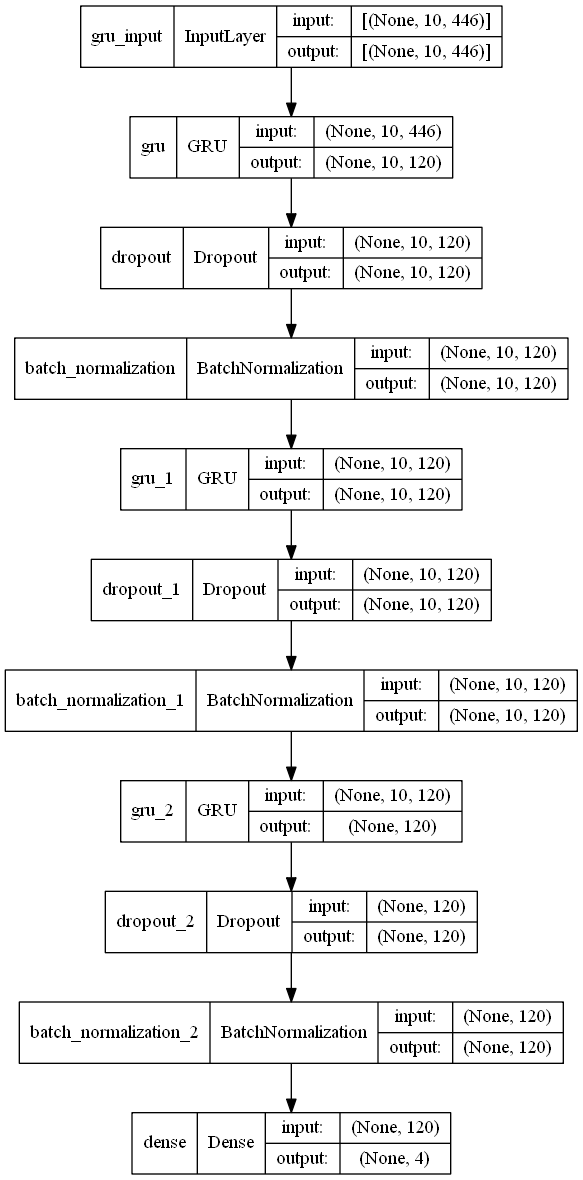

In [18]:
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath="1GRU.h5",
                               mode='min', monitor='val_loss', verbose=0, save_best_only=True)
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True)

In [20]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[cp, early_stop]
                    ).history

Epoch 1/5
2168/2168 [==============================] - 27s 11ms/step - loss: 0.0793 - accuracy: 0.9751 - val_loss: 0.0139 - val_accuracy: 0.9979
Epoch 2/5
2168/2168 [==============================] - 23s 10ms/step - loss: 0.0187 - accuracy: 0.9970 - val_loss: 0.0105 - val_accuracy: 0.9987
Epoch 3/5
2168/2168 [==============================] - 23s 10ms/step - loss: 0.0141 - accuracy: 0.9979 - val_loss: 0.0078 - val_accuracy: 0.9989
Epoch 4/5
2168/2168 [==============================] - 23s 10ms/step - loss: 0.0116 - accuracy: 0.9984 - val_loss: 0.0083 - val_accuracy: 0.9989
Epoch 5/5
2168/2168 [==============================] - 23s 10ms/step - loss: 0.0102 - accuracy: 0.9986 - val_loss: 0.0072 - val_accuracy: 0.9989


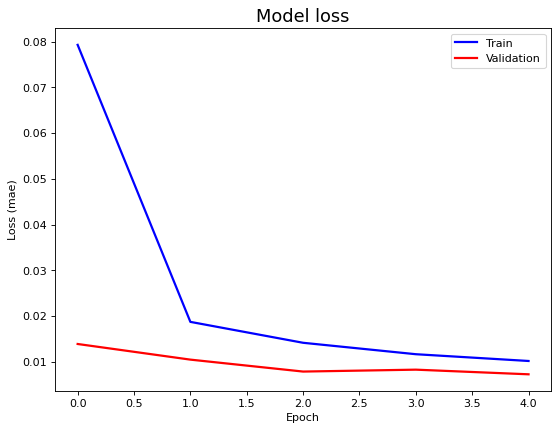

In [21]:
# plot the training losses
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
ax.plot(model.history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(model.history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [22]:
#Prediction
pred = model.predict(X_test)
#obj = scaler.fit(y_pred)
#predicted = obj.inverse_transform(y_pred)

In [23]:
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(pred, axis=1)
# label
y_test = np.argmax(y_test, axis=1)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[7394    1    1    2]
 [   0 2365    0    0]
 [   0    0 2408    1]
 [   8    2    1 2417]]


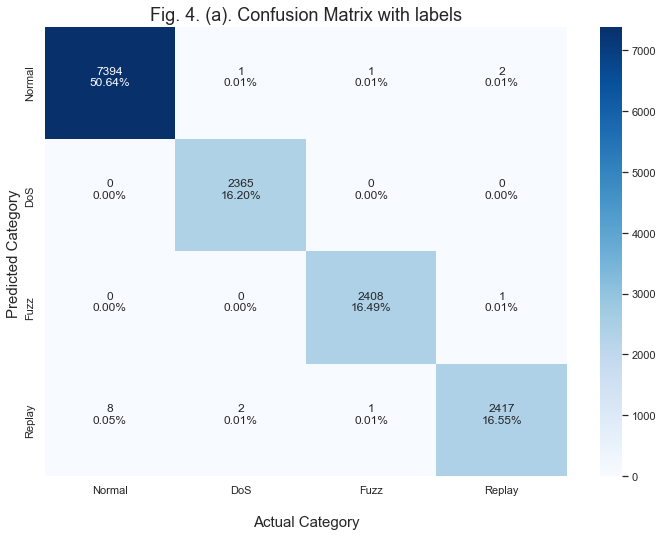

In [24]:
#group_names = ['True Neg','False Pos','False Neg','True Pos','True Pos','True Pos','True Pos','True Pos','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(4,4)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Fig. 4. (a). Confusion Matrix with labels', fontsize=18);
ax.set_xlabel('\nActual Category', fontsize=15)
ax.set_ylabel('Predicted Category ', fontsize=15);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Normal", "DoS", "Fuzz", "Replay"])
ax.yaxis.set_ticklabels(["Normal", "DoS", "Fuzz", "Replay"])

## Display the visualization of the Confusion Matrix.
plt.show()

In [25]:
from sklearn.metrics import classification_report
class_names = ["Normal", "DoS", "Fuzz", "Replay"]
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      7398
         DoS       1.00      1.00      1.00      2365
        Fuzz       1.00      1.00      1.00      2409
      Replay       1.00      1.00      1.00      2428

    accuracy                           1.00     14600
   macro avg       1.00      1.00      1.00     14600
weighted avg       1.00      1.00      1.00     14600



ROC AUC score: 0.9990934002568537


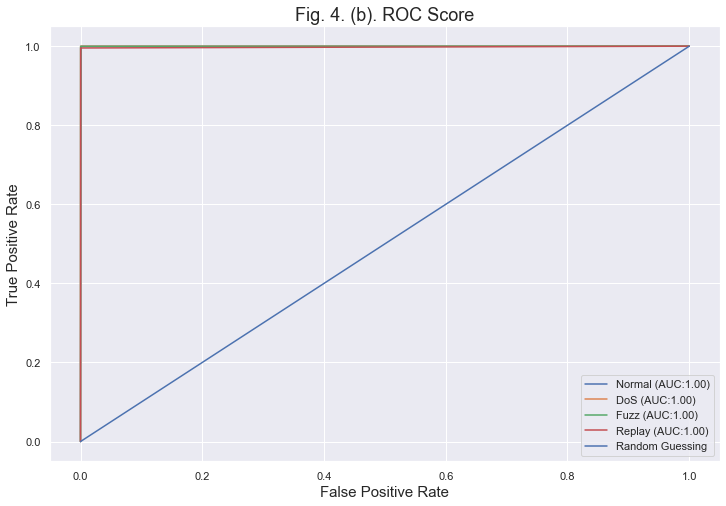

In [26]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ["Normal", "DoS", "Fuzz", "Replay"]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test, y_pred))

c_ax.legend()
c_ax.set_title('Fig. 4. (b). ROC Score', fontsize=18);
c_ax.set_xlabel('False Positive Rate', fontsize=15)
c_ax.set_ylabel('True Positive Rate', fontsize=15)
plt.show()